# Q6 (Bonus): Neural Collapse on Earlier Layers (NC1-NC5)

This notebook studies how **all five Neural Collapse properties** emerge progressively through network depth.

| Metric | What it measures | Where computed |
|--------|-----------------|----------------|
| **NC1** | Within-class variability collapse | ALL layers |
| **NC2** equinorm | Class-mean norms equality | ALL layers |
| **NC2** equiangularity | Simplex ETF structure | ALL layers |
| **NC3** | Self-duality (W ~ M) | Penultimate only (needs classifier W) |
| **NC4** | NCC agreement with network | ALL layers |
| **NC5** | ID/OOD orthogonality | ALL layers (needs OOD data) |

- NC forms **last-to-first** -- the penultimate layer collapses first
- Collapse propagates backward through the network during extended training
- Earlier layers may never fully collapse, especially if D < C

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
if not os.path.exists('/content/OOD-Detection-Project---CSC_5IA23'):
    !git clone https://github.com/DiegoFleury/OOD-Detection-Project---CSC_5IA23/
%cd /content/OOD-Detection-Project---CSC_5IA23

Cloning into 'OOD-Detection-Project---CSC_5IA23'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 356 (delta 189), reused 266 (delta 110), pack-reused 0 (from 0)
Receiving objects: 100% (356/356), 8.73 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (189/189), done.
/content/OOD-Detection-Project---CSC_5IA23


In [3]:
!pip install -q torch torchvision matplotlib seaborn scikit-learn pyyaml imageio tqdm

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
import glob
import re
import os

from src.models import ResNet18
from src.data import get_cifar100_loaders

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [5]:
with open('configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration:")
print(yaml.dump(config, default_flow_style=False))

Configuration:
data:
  augment: true
  data_dir: ./data
  num_workers: 2
device: cuda
model:
  num_classes: 100
ood:
  datasets:
  - SVHN
  - CIFAR10
  - Textures
  sampling_ratio: 0.1
  tpt_mask:
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 1
  - 1
  - 1
  - 1
paths:
  checkpoints: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints
  figures: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures
  gifs: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/gifs
  metrics: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics
  ood_detection: /content/drive/MyDrive/Colab Notebooks/OOD/Results/ood_scoring
  results: /content/drive/MyDrive/Colab Notebooks/OOD/Results
  tables: /content/drive/MyDrive/Colab Notebooks/OOD/Results/tables
training:
  batch_size: 128
  checkpoint_frequency: 25
  early_stopping_patience: 999
  epochs: 300
  lr: 0.1
  momentum: 0.9
  val_split: 0.1
  weight_decay: 0.0005



## 1. Load Data

- **CIFAR-100** (ID) -- for NC1-NC4
- **SVHN** (OOD) -- for NC5

In [6]:
print("Loading CIFAR-100 (ID)...")

train_loader, val_loader, test_loader = get_cifar100_loaders(
    data_dir=config['data']['data_dir'],
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    augment=False,
    val_split=config['training']['val_split']
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches:  {len(test_loader)}")

Loading CIFAR-100 (ID)...


100%|██████████| 169M/169M [00:03<00:00, 48.5MB/s]


Train batches: 352
Test batches:  79


In [7]:
import torchvision
import torchvision.transforms as transforms

ood_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    ),
])

print("Loading SVHN (OOD for NC5)...")
svhn_dataset = torchvision.datasets.SVHN(
    root=config['data']['data_dir'], split='test',
    transform=ood_transform, download=True,
)
svhn_loader = torch.utils.data.DataLoader(
    svhn_dataset, batch_size=config['training']['batch_size'],
    shuffle=False, num_workers=config['data']['num_workers'],
)
print(f"SVHN test samples: {len(svhn_dataset)}")

Loading SVHN (OOD for NC5)...


100%|██████████| 64.3M/64.3M [00:02<00:00, 27.5MB/s]


SVHN test samples: 26032


## 2. Load Model

In [8]:
model = ResNet18(num_classes=config['model']['num_classes'])

checkpoint_dir = config['paths']['checkpoints']
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))

def get_epoch_num(path):
    match = re.search(r'epoch(\d+)', path)
    return int(match.group(1)) if match else 0

latest = max(checkpoints, key=get_epoch_num)
epoch_num = get_epoch_num(latest)

ckpt = torch.load(latest, map_location=device, weights_only=False)
if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
    model.load_state_dict(ckpt['model_state_dict'])
elif isinstance(ckpt, dict) and 'state_dict' in ckpt:
    model.load_state_dict(ckpt['state_dict'])
else:
    model.load_state_dict(ckpt)

model = model.to(device)
model.eval()

print(f"Loaded: {os.path.basename(latest)} (epoch {epoch_num})")

Loaded: resnet18_cifar100_epoch300.pth (epoch 300)


## 3. Import Module

In [9]:
from src.neural_collapse.nc_earlier_layer import (
    analyze_layers_single_checkpoint,
    analyze_layers_across_checkpoints,
    plot_nc_by_layer,
    plot_nc_layers_across_epochs,
    plot_nc_heatmap,
    save_layer_metrics_yaml,
    LayerNCResult,
    LayerNCTracker,
)

print("NC earlier layer module imported.")

NC earlier layer module imported.


In [10]:
figures_dir = os.path.join(config['paths']['figures'], 'nc_layers')
metrics_dir = config['paths']['metrics']
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

## 4. NC1-NC5 Across Layers (Final Checkpoint)

ResNet-18 architecture:

| Layer | Feature dim D | Spatial | D vs C=100 |
|-------|--------------|---------|------------|
| layer1 | 64 | 32x32 | D < C  NC1 ill-conditioned |
| layer2 | 128 | 16x16 | D > C |
| layer3 | 256 | 8x8 | D > C |
| layer4 | 512 | 4x4 | D > C |
| penultimate | 512 | (GAP) | D > C |

Features at each layer are Global-Average-Pooled to (B, D) before computing metrics.
NC5 uses SVHN as OOD data.

In [11]:
print("Computing NC1-NC5 at each layer (final checkpoint)...")
print(f"   Model: ResNet-18 / CIFAR-100 (epoch {epoch_num})")
print(f"   OOD: SVHN (for NC5)")
print(f"   Device: {device}")
print()

layer_results = analyze_layers_single_checkpoint(
    model=model,
    loader=train_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    layer_names=['layer1', 'layer2', 'layer3', 'layer4'],
    include_penultimate=True,
    ood_loader=svhn_loader,
)

print(f"{'Layer':<14s} {'D':>4s} {'NC1':>9s} {'NC2norm':>9s} {'NC2ang':>9s}"
      f" {'NC3':>9s} {'NC4':>9s} {'NC5':>9s}")
print("-" * 80)
for r in layer_results:
    nc3 = f"{r.nc3_w_m_dist:.4f}" if r.nc3_w_m_dist is not None else "    ---"
    nc4 = f"{r.nc4_ncc_mismatch:.4f}" if r.nc4_ncc_mismatch is not None else "    ---"
    nc5 = f"{r.nc5_orthodev:.4f}" if r.nc5_orthodev is not None else "    ---"
    print(f"{r.layer_name:<14s} {r.feature_dim:>4d} {r.nc1:>9.4f} "
          f"{r.nc2_equinorm:>9.4f} {r.nc2_equiangularity:>9.4f} "
          f"{nc3:>9s} {nc4:>9s} {nc5:>9s}")

Computing NC1-NC5 at each layer (final checkpoint)...
   Model: ResNet-18 / CIFAR-100 (epoch 300)
   OOD: SVHN (for NC5)
   Device: cuda

Layer             D       NC1   NC2norm    NC2ang       NC3       NC4       NC5
--------------------------------------------------------------------------------
layer1           64   89.0935    0.4319    0.3633       ---    0.8656    0.9411
layer2          128  212.7567    0.3166    0.2966       ---    0.7444    0.8741
layer3          256   19.0391    0.2759    0.1920       ---    0.4861    0.7122
layer4          512    0.1255    0.0377    0.0567       ---    0.0000    0.3531
penultimate     512    0.1255    0.0377    0.0567    0.0389    0.0000    0.3531


 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/nc_layers/nc_by_layer.png


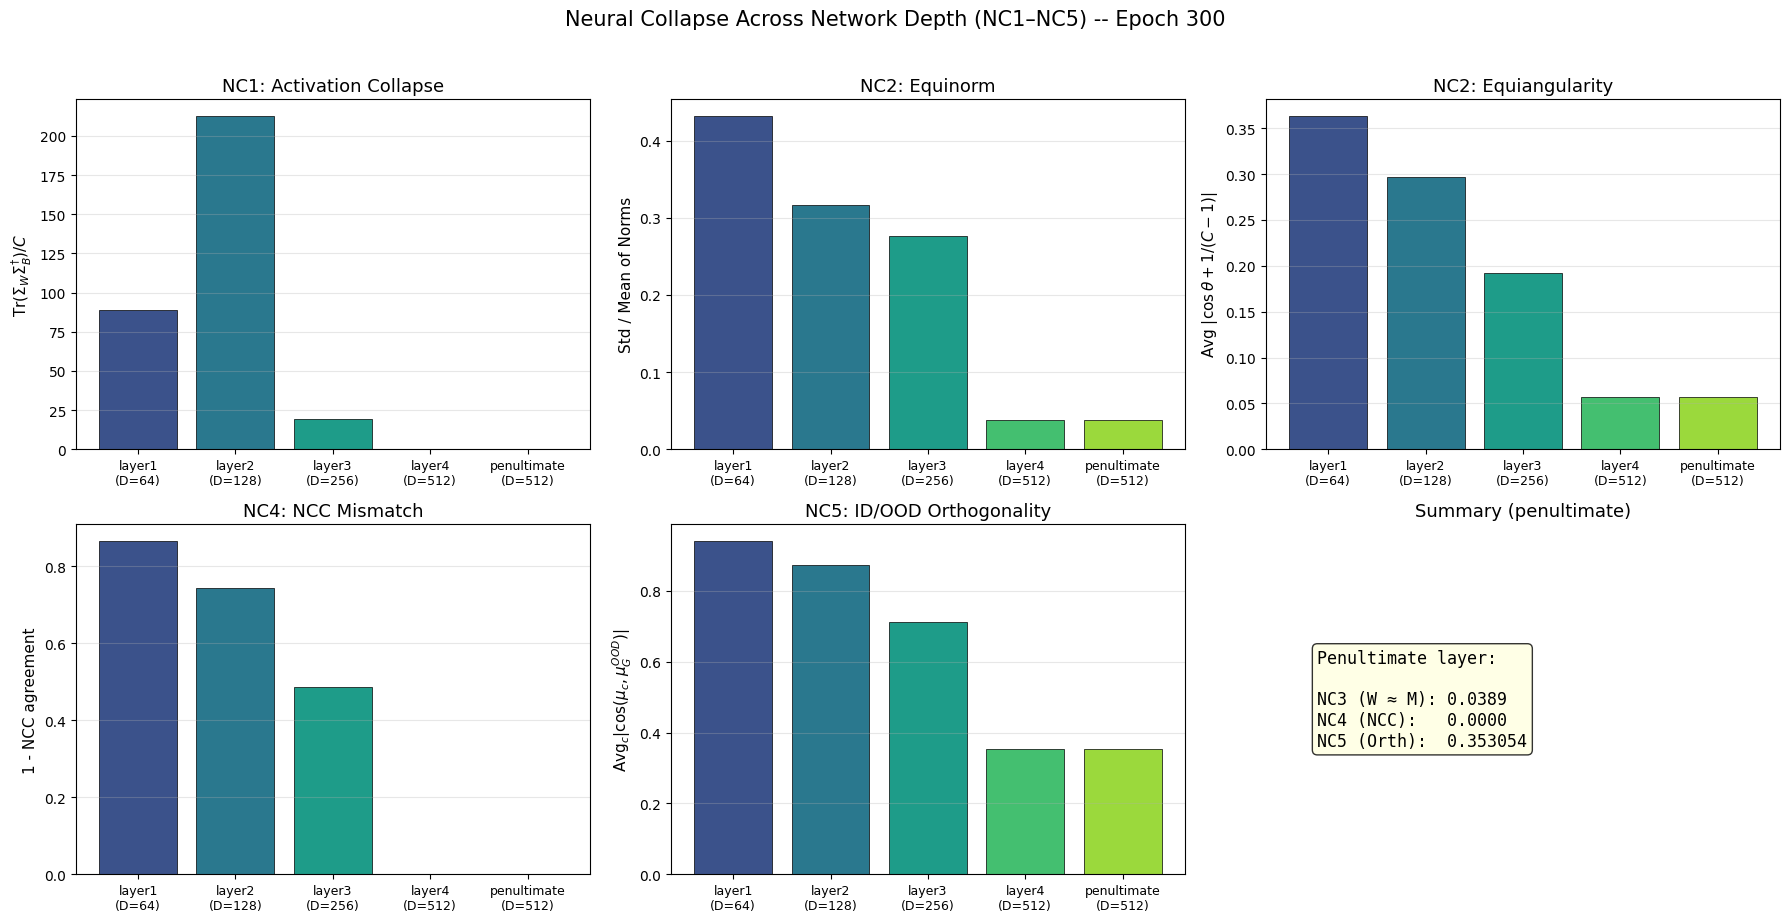

In [12]:
fig_bars = plot_nc_by_layer(
    layer_results,
    title_suffix=f" -- Epoch {epoch_num}",
    save_dir=figures_dir,
)
plt.show()

### 4.1 Interpretation

In [13]:
print("\n" + "=" * 70)
print("LAYER-WISE NC1-NC5 ANALYSIS")
print("=" * 70)

print("\n--- NC1: Activation Collapse (shallow -> deep) ---")
for r in layer_results:
    bar_len = min(int(r.nc1 / max(lr.nc1 for lr in layer_results) * 30), 30)
    bar = "#" * bar_len
    note = "   D < C" if r.feature_dim < config['model']['num_classes'] else ""
    print(f"  {r.layer_name:<14s} (D={r.feature_dim:>3d}) NC1={r.nc1:>8.2f}  {bar}{note}")

print("\n--- NC4: NCC Agreement (shallow -> deep) ---")
for r in layer_results:
    if r.nc4_ncc_mismatch is not None:
        agreement = (1 - r.nc4_ncc_mismatch) * 100
        bar = "#" * int(agreement / 100 * 30)
        print(f"  {r.layer_name:<14s} NCC agrees with network: {agreement:.1f}%  {bar}")

print("\n--- NC5: ID/OOD Orthogonality (shallow -> deep) ---")
for r in layer_results:
    if r.nc5_orthodev is not None:
        print(f"  {r.layer_name:<14s} OrthoDev = {r.nc5_orthodev:.4f}")

pen = next((r for r in layer_results if r.layer_name == 'penultimate'), None)
if pen and pen.nc3_w_m_dist is not None:
    print(f"\n--- NC3: Self-Duality (penultimate only) ---")
    print(f"  ||W^T - M||^2 = {pen.nc3_w_m_dist:.4f}")

nc1_list = [r.nc1 for r in layer_results]
monotonic = all(nc1_list[i] >= nc1_list[i+1] for i in range(len(nc1_list)-1))
print(f"\nNC1 monotonically decreasing: {monotonic}")

ratio = layer_results[0].nc1 / layer_results[-1].nc1 if layer_results[-1].nc1 > 0 else float('inf')
print(f"NC1 ratio (shallowest / deepest): {ratio:.1f}x")

print("\n" + "=" * 70)


LAYER-WISE NC1-NC5 ANALYSIS

--- NC1: Activation Collapse (shallow -> deep) ---
  layer1         (D= 64) NC1=   89.09  ############   D < C
  layer2         (D=128) NC1=  212.76  ##############################
  layer3         (D=256) NC1=   19.04  ##
  layer4         (D=512) NC1=    0.13  
  penultimate    (D=512) NC1=    0.13  

--- NC4: NCC Agreement (shallow -> deep) ---
  layer1         NCC agrees with network: 13.4%  ####
  layer2         NCC agrees with network: 25.6%  #######
  layer3         NCC agrees with network: 51.4%  ###############
  layer4         NCC agrees with network: 100.0%  ##############################
  penultimate    NCC agrees with network: 100.0%  ##############################

--- NC5: ID/OOD Orthogonality (shallow -> deep) ---
  layer1         OrthoDev = 0.9411
  layer2         OrthoDev = 0.8741
  layer3         OrthoDev = 0.7122
  layer4         OrthoDev = 0.3531
  penultimate    OrthoDev = 0.3531

--- NC3: Self-Duality (penultimate only) ---
  ||W^T -

## 5. NC Propagation Across Training Epochs

We compute NC1-NC5 at each layer for each checkpoint.
This reveals the **temporal dynamics** of how collapse propagates backward.

In [14]:
print("Analysing NC1-NC5 across layers AND epochs...")
print(f"   (one forward pass per checkpoint x {4+1} layers + OOD pass)")
print()

tracker = analyze_layers_across_checkpoints(
    checkpoint_dir=checkpoint_dir,
    model_class=ResNet18,
    loader=train_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    layer_names=['layer1', 'layer2', 'layer3', 'layer4'],
    ood_loader=svhn_loader,
    checkpoint_pattern='resnet18_cifar100_*.pth',
    epoch_regex=r'epoch(\d+)',
    verbose=True,
)

print("\n" + tracker.summary())

Analysing NC1-NC5 across layers AND epochs...
   (one forward pass per checkpoint x 5 layers + OOD pass)



Layer NC Analysis:   8%|▊         | 1/13 [00:49<09:56, 49.70s/it]

  Epoch    0 | layer1:NC1=87.82 NC4=0.87 NC5=0.941 | layer2:NC1=213.21 NC4=0.74 NC5=0.874 | layer3:NC1=19.16 NC4=0.49 NC5=0.714 | layer4:NC1=0.13 NC4=0.00 NC5=0.347 | penultimate:NC1=0.13 NC4=0.00 NC5=0.347


Layer NC Analysis:  15%|█▌        | 2/13 [01:37<08:54, 48.57s/it]

  Epoch   25 | layer1:NC1=83.14 NC4=0.89 NC5=0.961 | layer2:NC1=292.64 NC4=0.81 NC5=0.874 | layer3:NC1=40.52 NC4=0.69 NC5=0.756 | layer4:NC1=4.98 NC4=0.39 NC5=0.459 | penultimate:NC1=4.98 NC4=0.39 NC5=0.459


Layer NC Analysis:  23%|██▎       | 3/13 [02:27<08:11, 49.15s/it]

  Epoch   50 | layer1:NC1=75.46 NC4=0.88 NC5=0.955 | layer2:NC1=238.35 NC4=0.79 NC5=0.884 | layer3:NC1=37.21 NC4=0.62 NC5=0.752 | layer4:NC1=3.38 NC4=0.28 NC5=0.518 | penultimate:NC1=3.38 NC4=0.28 NC5=0.518


Layer NC Analysis:  31%|███       | 4/13 [03:19<07:31, 50.20s/it]

  Epoch   75 | layer1:NC1=91.05 NC4=0.88 NC5=0.953 | layer2:NC1=233.29 NC4=0.79 NC5=0.866 | layer3:NC1=34.26 NC4=0.64 NC5=0.761 | layer4:NC1=3.06 NC4=0.26 NC5=0.503 | penultimate:NC1=3.06 NC4=0.26 NC5=0.503


Layer NC Analysis:  38%|███▊      | 5/13 [04:07<06:36, 49.58s/it]

  Epoch  100 | layer1:NC1=92.32 NC4=0.88 NC5=0.947 | layer2:NC1=245.81 NC4=0.78 NC5=0.883 | layer3:NC1=32.10 NC4=0.62 NC5=0.739 | layer4:NC1=2.48 NC4=0.20 NC5=0.492 | penultimate:NC1=2.48 NC4=0.20 NC5=0.492


Layer NC Analysis:  46%|████▌     | 6/13 [04:56<05:46, 49.51s/it]

  Epoch  125 | layer1:NC1=81.72 NC4=0.88 NC5=0.948 | layer2:NC1=238.21 NC4=0.78 NC5=0.892 | layer3:NC1=31.77 NC4=0.63 NC5=0.744 | layer4:NC1=2.16 NC4=0.17 NC5=0.505 | penultimate:NC1=2.16 NC4=0.17 NC5=0.505


Layer NC Analysis:  54%|█████▍    | 7/13 [05:48<05:00, 50.09s/it]

  Epoch  150 | layer1:NC1=82.91 NC4=0.87 NC5=0.942 | layer2:NC1=219.00 NC4=0.78 NC5=0.878 | layer3:NC1=30.03 NC4=0.62 NC5=0.766 | layer4:NC1=1.92 NC4=0.14 NC5=0.495 | penultimate:NC1=1.92 NC4=0.14 NC5=0.495


Layer NC Analysis:  62%|██████▏   | 8/13 [06:37<04:09, 49.96s/it]

  Epoch  175 | layer1:NC1=84.14 NC4=0.87 NC5=0.943 | layer2:NC1=225.00 NC4=0.77 NC5=0.880 | layer3:NC1=28.09 NC4=0.60 NC5=0.717 | layer4:NC1=1.61 NC4=0.12 NC5=0.504 | penultimate:NC1=1.61 NC4=0.12 NC5=0.504


Layer NC Analysis:  69%|██████▉   | 9/13 [07:27<03:19, 49.87s/it]

  Epoch  200 | layer1:NC1=81.68 NC4=0.87 NC5=0.941 | layer2:NC1=206.11 NC4=0.76 NC5=0.886 | layer3:NC1=27.19 NC4=0.59 NC5=0.765 | layer4:NC1=1.12 NC4=0.04 NC5=0.510 | penultimate:NC1=1.12 NC4=0.04 NC5=0.510


Layer NC Analysis:  77%|███████▋  | 10/13 [08:17<02:30, 50.01s/it]

  Epoch  225 | layer1:NC1=92.90 NC4=0.87 NC5=0.941 | layer2:NC1=248.34 NC4=0.76 NC5=0.881 | layer3:NC1=24.92 NC4=0.56 NC5=0.730 | layer4:NC1=0.64 NC4=0.01 NC5=0.479 | penultimate:NC1=0.64 NC4=0.01 NC5=0.479


Layer NC Analysis:  85%|████████▍ | 11/13 [09:07<01:39, 49.77s/it]

  Epoch  250 | layer1:NC1=86.58 NC4=0.87 NC5=0.941 | layer2:NC1=209.16 NC4=0.75 NC5=0.872 | layer3:NC1=20.71 NC4=0.51 NC5=0.713 | layer4:NC1=0.21 NC4=0.00 NC5=0.380 | penultimate:NC1=0.21 NC4=0.00 NC5=0.380


Layer NC Analysis:  92%|█████████▏| 12/13 [09:57<00:49, 49.94s/it]

  Epoch  275 | layer1:NC1=88.30 NC4=0.87 NC5=0.941 | layer2:NC1=211.99 NC4=0.74 NC5=0.875 | layer3:NC1=19.36 NC4=0.49 NC5=0.718 | layer4:NC1=0.14 NC4=0.00 NC5=0.342 | penultimate:NC1=0.14 NC4=0.00 NC5=0.342


Layer NC Analysis: 100%|██████████| 13/13 [10:45<00:00, 49.65s/it]

  Epoch  300 | layer1:NC1=89.10 NC4=0.87 NC5=0.941 | layer2:NC1=212.75 NC4=0.74 NC5=0.874 | layer3:NC1=19.04 NC4=0.49 NC5=0.712 | layer4:NC1=0.13 NC4=0.00 NC5=0.353 | penultimate:NC1=0.13 NC4=0.00 NC5=0.353

LAYER-WISE NEURAL COLLAPSE SUMMARY  (NC1–NC5)
Epochs analyzed: 13
Epoch range: 0 → 300

Layer               NC1  Equinorm   Equiang      NC4      NC5
-------------------------------------------------------------
layer1          89.0964    0.4319    0.3633   0.8656   0.9411
layer2         212.7510    0.3166    0.2966   0.7444   0.8741
layer3          19.0391    0.2759    0.1920   0.4861   0.7122
layer4           0.1255    0.0377    0.0567   0.0000   0.3531
penultimate      0.1255    0.0377    0.0567   0.0000   0.3531


### 5.1 Line Plots -- NC per Layer Across Epochs

Each line = one layer. Watch collapse propagate from `penultimate` to `layer1`.

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/nc_layers/nc_layers_across_epochs.png


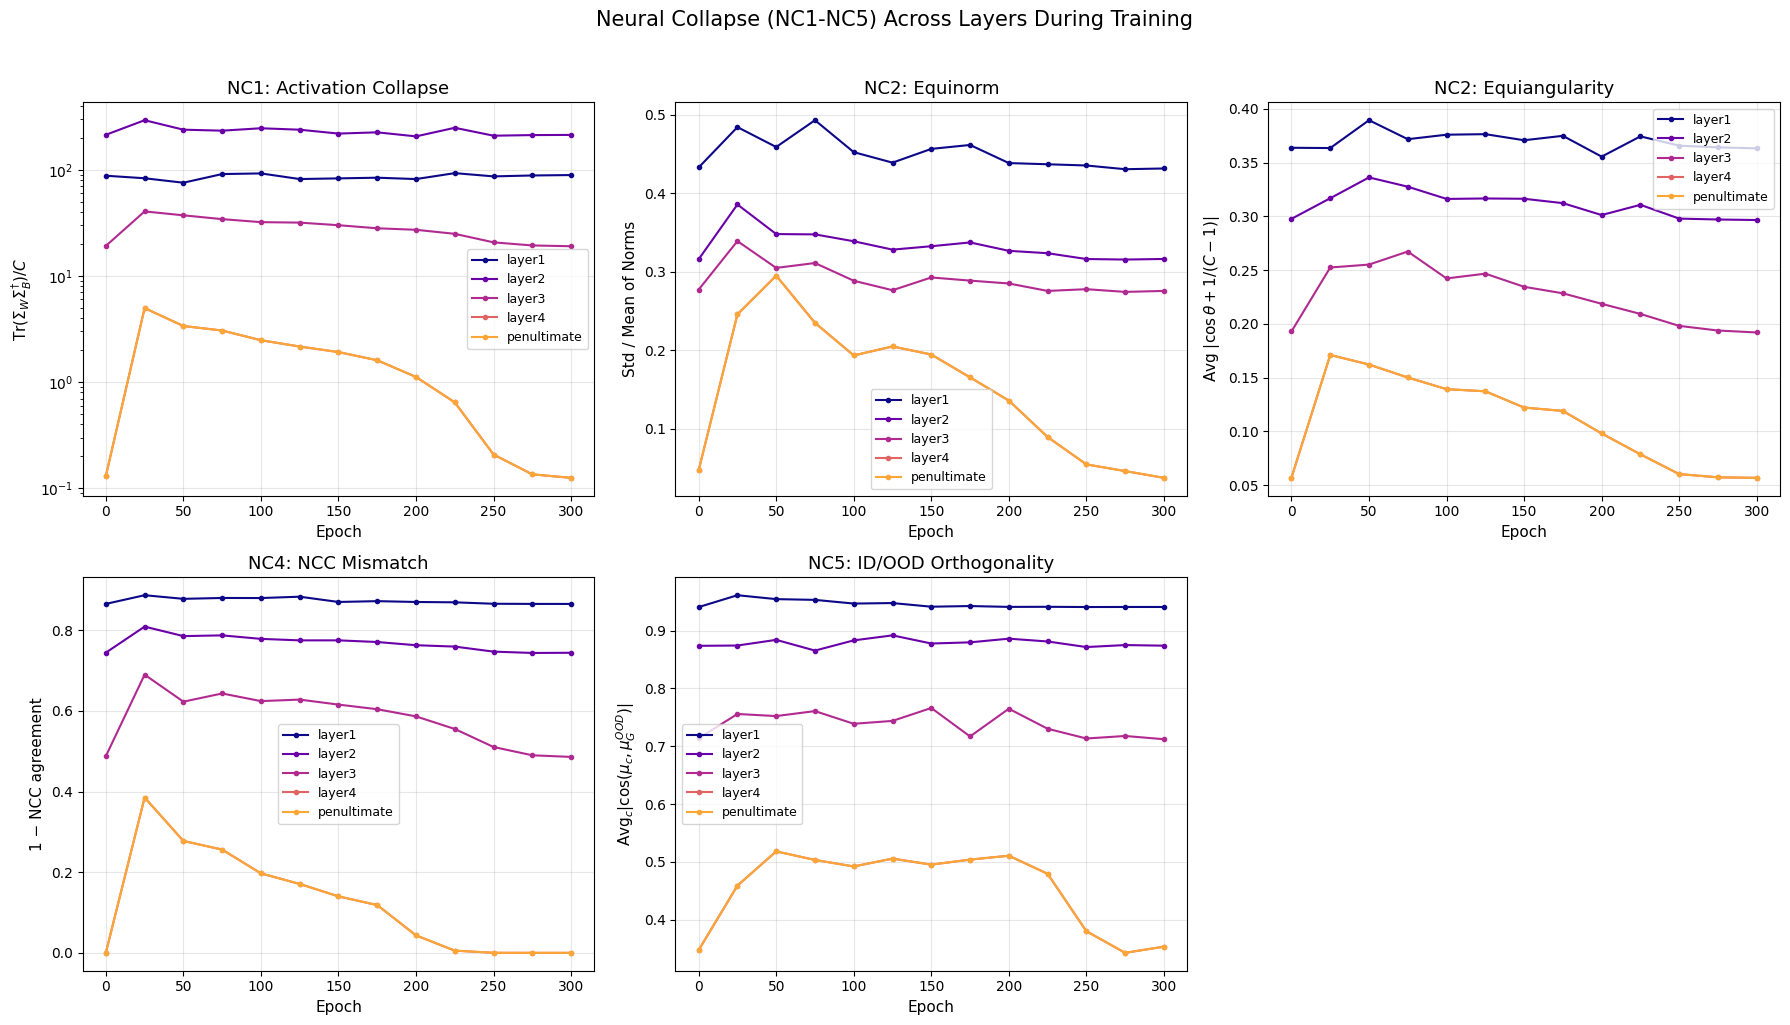

In [15]:
fig_lines = plot_nc_layers_across_epochs(
    tracker, save_dir=figures_dir,
)
plt.show()

### 5.2 Heatmaps -- Collapse Propagation

Heatmaps (layer x epoch) reveal the backward propagation of collapse:
darker colours = more collapsed. The bottom rows (deep layers) should darken first.

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/nc_layers/nc_heatmap_nc1.png


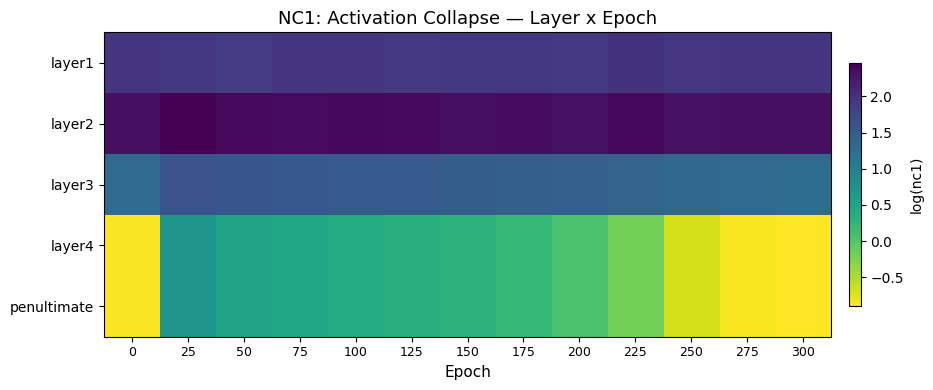

In [16]:
fig_hm1 = plot_nc_heatmap(tracker, metric='nc1', save_dir=figures_dir)
plt.show()

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/nc_layers/nc_heatmap_nc4_ncc_mismatch.png


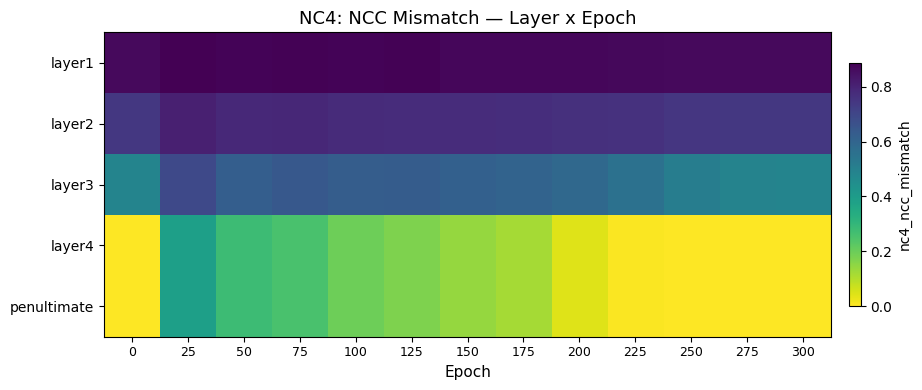

In [17]:
fig_hm_nc4 = plot_nc_heatmap(tracker, metric='nc4_ncc_mismatch', save_dir=figures_dir)
plt.show()

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/nc_layers/nc_heatmap_nc5_orthodev.png


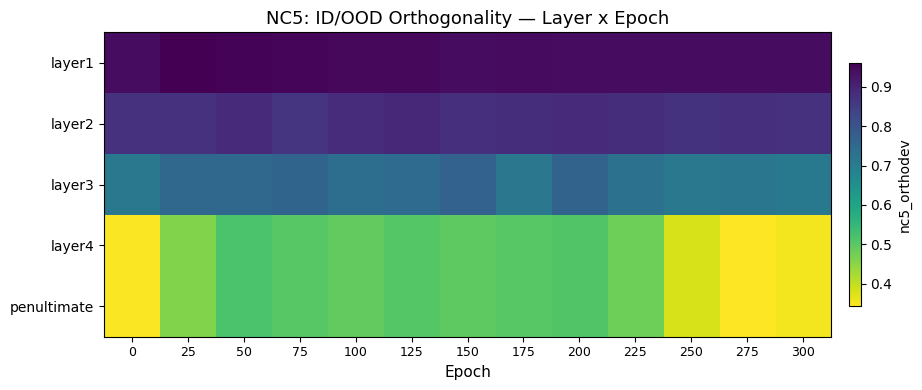

In [18]:
fig_hm_nc5 = plot_nc_heatmap(tracker, metric='nc5_orthodev', save_dir=figures_dir)
plt.show()

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/nc_layers/nc_heatmap_nc2_equiangularity.png


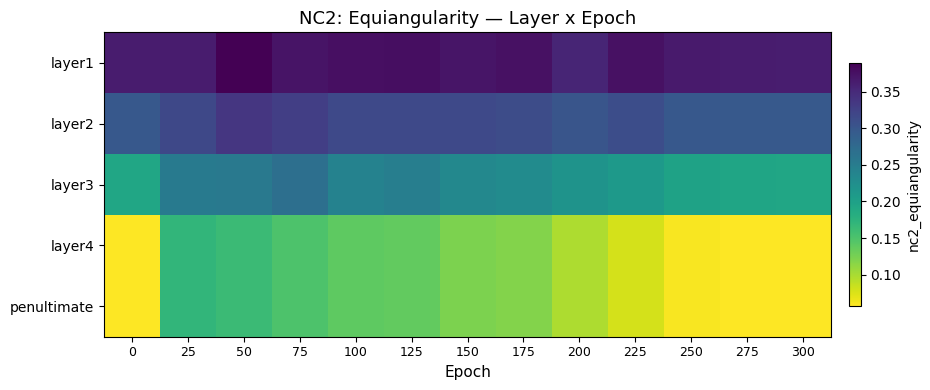

In [19]:
fig_hm2 = plot_nc_heatmap(tracker, metric='nc2_equiangularity', save_dir=figures_dir)
plt.show()

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/nc_layers/nc_heatmap_nc2_equinorm.png


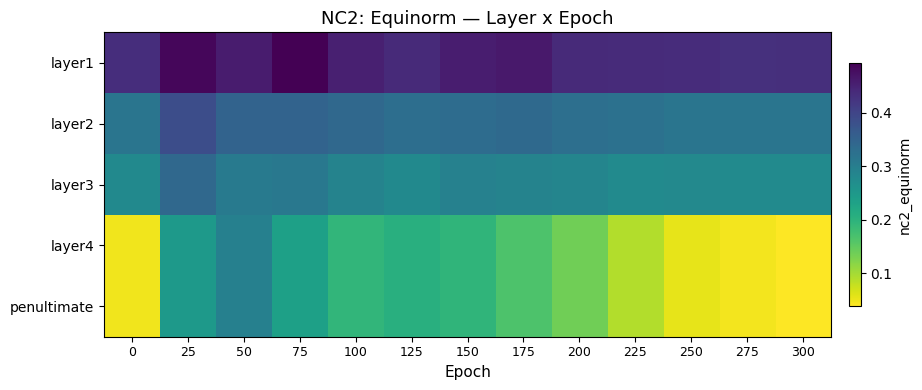

In [20]:
fig_hm3 = plot_nc_heatmap(tracker, metric='nc2_equinorm', save_dir=figures_dir)
plt.show()

## 6. Save Metrics

In [21]:
save_layer_metrics_yaml(
    tracker,
    os.path.join(metrics_dir, 'nc_earlier_layers_metrics.yaml'),
)

import json

single_results = []
for r in layer_results:
    d = {
        'layer': r.layer_name,
        'feature_dim': r.feature_dim,
        'nc1': r.nc1,
        'nc2_equinorm': r.nc2_equinorm,
        'nc2_equiangularity': r.nc2_equiangularity,
    }
    if r.nc3_w_m_dist is not None:
        d['nc3_w_m_dist'] = r.nc3_w_m_dist
    if r.nc4_ncc_mismatch is not None:
        d['nc4_ncc_mismatch'] = r.nc4_ncc_mismatch
    if r.nc5_orthodev is not None:
        d['nc5_orthodev'] = r.nc5_orthodev
    single_results.append(d)

json_path = os.path.join(metrics_dir, 'nc_earlier_layers_final.json')
with open(json_path, 'w') as f:
    json.dump({
        'epoch': epoch_num,
        'ood_dataset': 'SVHN',
        'layers': single_results,
    }, f, indent=2)
print(f"Saved: {json_path}")

 Layer metrics saved to: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_earlier_layers_metrics.yaml
Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_earlier_layers_final.json
